# Analyzing ChIP-seq data

### ChIP-seq introduction

**Ch**romatin **I**mmuno**p**recipitation **se**quencing (ChIP-seq) is a method to analyze target protein interactions with DNA. Two common types of targets for ChIP-seq are histone marks (e.g. H3K27ac) and transcription factors (e.g. MYC). When we perform ChIP-seq assays on these targets, we can learn which areas of the genome contain histone modifications or transcription factor binding sites. While histone marks tend to span large regions up to thousands of kilobases, transcription factors in general form punctate narrow peaks over smaller regions. When we analyze ChIP-seq data, one of the basic analyses is calling "peaks" from the reads which are basically regions where lots of reads pile up. This indicates regions that are preferentially pulled down from our targeted assay.

### Histone Marks

The 3 histone marks that we'll cover in this notebook are H3K4me1, H3K4me3, and H3K27ac. Combinations of these marks typically are found at active enhancers (H3K4me1 + H3K27ac), active promoters (H3K4me3 + H3K27ac), and poised enhancers (H3K4me1 only). Different cell types have differential expression of genes - we can quantify this with RNA-seq, or we can dive into how the genes are regulated at the chromatin level. The ENCODE and Roadmap consortiums have generated an immense amount of ChIP-seq data that we can use to study cell-type specific active enhancers and promoters. 

Here's a table to summarize this information.

Chromatin State | Histone Mark(s)
--- | ---
Active Enhancer | H3K4me1 + H3K27ac
Active Promoter | H3K4me3 + H3K27ac
Poised Enhancer | H3K4me1 only

#### Practicing with public datasets

One of the ways that we can use this information to our advantage is to combine ChIP-seq peaks from different histone marks of the same cell type. Let's look at [histone marks for H1 hESC](https://www.encodeproject.org/search/?type=Experiment&assay_title=ChIP-seq&replicates.library.biosample.donor.organism.scientific_name=Homo+sapiens&biosample_term_name=H1-hESC&target.investigated_as=histone+modification&lab.title=Bing+Ren%2C+UCSD), a human embryonic cell line that has ChIP-seq data from Roadmap.

We can download processed BED files for these 3 histone marks with these commands - note I'm downloading the hg19 replicated peaks for H3K4me1, H3K4me3, and H3K27ac assays performed in H1 hESC.

    wget https://www.encodeproject.org/files/ENCFF834NWA/@@download/ENCFF834NWA.bed.gz
    wget https://www.encodeproject.org/files/ENCFF865TYO/@@download/ENCFF865TYO.bed.gz
    wget https://www.encodeproject.org/files/ENCFF335JSA/@@download/ENCFF335JSA.bed.gz

Now that we have some peaks to work with, let's unzip the files with `gunzip` and rename the files into something that's easier to remember.

    gunzip *.bed.gz
    mv ENCFF834NWA.bed H1_hESC.H3K4me1.bed
    mv ENCFF865TYO.bed H1_hESC.H3K4me3.bed
    mv ENCFF335JSA.bed H1_hESC.H3K27ac.bed

How many peaks do we have in total? We can use `wc` with the `-l` flag to check how many lines the file contains.

    wc -l *.bed
    
You should get a result that looks something like this. We see that H3K4me3 has the fewest peaks, while H3K4me1 has the most. 
```
   37087 H1_hESC.H3K4me3.bed
  167837 H1_hESC.H3K4me1.bed
   76063 H1_hESC.H3K27ac.bed
  280987 total
```

Does this make sense biologically? Yes, as there are fewer promoters (H3K4me3 + H3K27ac) than enhancers (H3K4me1 + H3K27ac) in the genome, and some enhancers are poised (H3K4me1 only). 

Now, we can use BEDtools to find our chromatin states for active enhancers, active promoters, and poised enhancers. We're going to use the `bedtools intersect` tool. Check out the [documentation](http://bedtools.readthedocs.io/en/latest/content/tools/intersect.html) to look up how to use this tool. 

For example, if we want to find out where the active enhancers are, we can use `bedtools intersect` to find out which genomic regions have both H3K4me1 and H3K27ac marks (We can do something similar for active promoters using H3K4me3 and H3K27ac marks). Let's also sort our files prior to redirecting our output.

    bedtools intersect -a H1_hESC.H3K4me1.bed -b H1_hESC.H3K27ac.bed  | bedtools sort -i - > H1_hESC.Active_Enhancers.bed
    bedtools intersect -a H1_hESC.H3K4me3.bed -b H1_hESC.H3K27ac.bed  | bedtools sort -i - > H1_hESC.Active_Promoters.bed
    
To find out which regions have ONLY H3K4me1 marks, let's hop back to the documentation for `bedtools intersect`. We see that the `-v` flag makes intersect inverse match entries in file A that have no overlaps in file B. Additionally, we can use multiple files for the `-b` flag. Putting this all together, we can use:

    bedtools intersect -v -a H1_hESC.H3K4me1.bed -b H1_hESC.H3K27ac.bed H1_hESC.H3K4me3.bed | bedtools sort -i - > H1_hESC.Poised_Enhancers.bed

Let's check how many regions we have for each chromatin state.

    wc -l H1_hESC.Active_Enhancers.bed H1_hESC.Active_Promoters.bed H1_hESC.Poised_Enhancers.bed
    
You should see an output that looks similar to this. Let's plot it!
    
```
   37959 H1_hESC.Active_Enhancers.bed
   25793 H1_hESC.Active_Promoters.bed
  119005 H1_hESC.Poised_Enhancers.bed
  182757 total
```

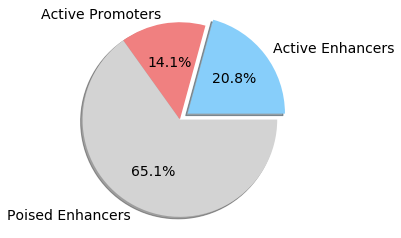

In [1]:
# import matplotlib, a module for plotting
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 14

# let's put our data into a list
labels = ['Active Enhancers', 'Active Promoters', 'Poised Enhancers']
counts = [37959, 25793, 119005]
colors = ['lightskyblue', 'lightcoral', 'lightgrey']
total = 182757

# making a pie plot
plt.pie(counts, explode=(0.1, 0, 0), labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True)
plt.axis('equal')
plt.show()

We see that by far, the largest category is poised enhancers. Active enhancers in H1 hESC constitute around 20.8% of the regions that we're looking at here. Let's look into transcription factor binding within these active enhancer regions.

### Transcription Factors

As you might already know, transcription factors play an important role in regulating gene expression and tend to bind at active enhancers. Let's take a look at some transcription factor ChIP-seq peaks and see how much overlap we have with our defined active enhancer state. Now that we know how to use `bedtools`, lets download a few more peak files (JUND, NRF1, USF2, MAX, TBP). This long command will download all 5 at once.


    wget https://www.encodeproject.org/files/ENCFF760AQQ/@@download/ENCFF760AQQ.bed.gz https://www.encodeproject.org/files/ENCFF508IBP/@@download/ENCFF508IBP.bed.gz https://www.encodeproject.org/files/ENCFF749OBU/@@download/ENCFF749OBU.bed.gz https://www.encodeproject.org/files/ENCFF002CRA/@@download/ENCFF002CRA.bed.gz https://www.encodeproject.org/files/ENCFF629MBV/@@download/ENCFF629MBV.bed.gz
    
Once again, let's `gunzip` these files and rename them.

    gunzip *.bed.gz
    mv ENCFF760AQQ.bed H1_hESC.JUND.TF.bed
    mv ENCFF508IBP.bed H1_hESC.NRF1.TF.bed
    mv ENCFF749OBU.bed H1_hESC.USF2.TF.bed
    mv ENCFF002CRA.bed H1_hESC.MAX.TF.bed
    mv ENCFF629MBV.bed H1_hESC.TBP.TF.bed
    
Now, let's see how many peaks for these transcription factors overlap our "Active Enhancer" regions. For this, we'll use a "for loop" to save on typing. For more information on a "for loop", check out this website [here](http://tldp.org/HOWTO/Bash-Prog-Intro-HOWTO-7.html). Also check out this page [here](https://ss64.com/bash/basename.html) to check out what basename does. Or simply just copy + paste the command and see what happens!

    for FILE in *.TF.bed; do bedtools intersect -a ${FILE} -b H1_hESC.Active_Enhancers.bed  | bedtools sort -i - > `basename ${FILE} .bed`.EnhA.bed; done

What this command does is `intersect` each of our transcription factor BED files with the Active Enhancer (EnhA) file that we've defined previously in the histone mark section. We then use basename to get the name of the transcription factor minus `.bed` , append `.EnhA.bed`, and redirect the output to that filename. 

Let's do a line count on the original transcription factor BED files, as well as the EnhA overlap BED files.

    wc -l *.TF.bed *.EnhA.bed
    
My command line outputs this for the active enhancer overlaps - let's make a plot to summarize our output.

```
  12684 H1_hESC.JUND.TF.bed
  11129 H1_hESC.MAX.TF.bed
   4829 H1_hESC.NRF1.TF.bed
  22071 H1_hESC.TBP.TF.bed
   8317 H1_hESC.USF2.TF.bed
   1178 H1_hESC.JUND.TF.EnhA.bed
   1050 H1_hESC.MAX.TF.EnhA.bed
     88 H1_hESC.NRF1.TF.EnhA.bed
   2044 H1_hESC.TBP.TF.EnhA.bed
    535 H1_hESC.USF2.TF.EnhA.bed
  63925 total
```

Can you do the same analysis for active promoters?  
I've plotted my results for active promoters below - try to see if you can replicate it.  


Why do you think the percent overlap is so much higher for the promoter regions? (Check out the scale bars for the graphs)  
**Hint: TBP is the TATA-box binding protein**.  
Check out more info about TBP on [GeneCards](http://www.genecards.org/cgi-bin/carddisp.pl?gene=TBP).  

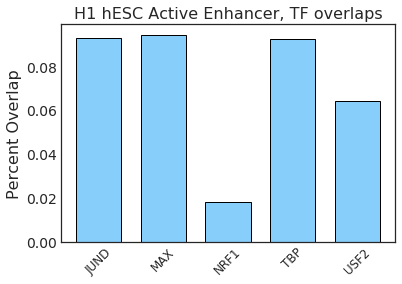

In [8]:
# import our plotting module
import numpy as np
import matplotlib.pyplot as plt

# let's put our data into a list
labels = ['JUND', 'MAX', 'NRF1', 'TBP', 'USF2']
overlaps = np.array([1178, 1050, 88, 2044, 535], dtype=np.float)
totals = np.array([12684, 11129, 4829, 22071, 8317], dtype=np.float)
percents = overlaps / totals

# make a bar chart
plt.style.use('seaborn-white')
plt.bar(range(0, len(labels)), percents, color='lightskyblue', edgecolor='black', linewidth=1, width=0.7)
plt.title('H1 hESC Active Enhancer, TF overlaps', fontsize=16)
plt.xticks(range(0, len(labels)), labels, rotation=45, fontsize=12)
plt.ylabel('Percent Overlap', fontsize=16)
plt.show()

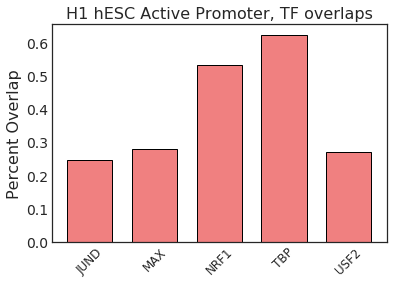

In [9]:
# let's put our data into a list
labels = ['JUND', 'MAX', 'NRF1', 'TBP', 'USF2']
overlaps = np.array([3139, 3116, 2567, 13759, 2248], dtype=np.float)
totals = np.array([12684, 11129, 4829, 22071, 8317], dtype=np.float)
percents = overlaps / totals

# make a bar chart
plt.style.use('seaborn-white')
plt.bar(range(0, len(labels)), percents, color='lightcoral', edgecolor='black', linewidth=1, width=0.7)
plt.title('H1 hESC Active Promoter, TF overlaps', fontsize=16)
plt.xticks(range(0, len(labels)), labels, rotation=45, fontsize=12)
plt.ylabel('Percent Overlap', fontsize=16)
plt.show()

## Functional Interpretation using GREAT

**G**enomic **R**egions **E**nrichment of **A**nnotations **T**ool (GREAT) is useful for analyzing the functional significance of cis-regulatory regions identified by localized measurements of DNA binding events across an entire genome. Think of it as gene ontology analysis, but for regulatory elements. Check out the paper [here](http://bejerano.stanford.edu/papers/GREAT.pdf).

We will use GREAT on our set of active enhancers to see what kind of results it predicts. **GREAT** requires a 2 sets of genomic regions in BED format - it requires (1) a set of test regions and (2) a set of background regions to calculate enrichment against (which is a super-set of the test regions, which basically means it has to contain our test regions + more). We're going to use the h1 hESC Active Enhancers (`H1_hESC.Active_Enhancers.bed`) as our test regions, and the set of all H3K4me1 marks (`H1_hESC.H3K4me1.bed`) as our background regions. Let's prepare these files for submission first.

    cut -f -3 H1_hESC.Active_Enhancers.bed > test_regions.bed
    cut -f -3 H1_hESC.H3K4me1.bed > background_regions.bed

First, let's open the web-based submission form for GREAT [here](http://bejerano.stanford.edu/great/public/html/). Let's upload our data and try using the default settings for association rule settings. You can play around with them if you want. 

**Species Assembly:** `Human: GRCh37 (UCSC hg19, Feb/2009)`  

**Test Regions:** BED file: `test_regions.bed`  

**Background Regions:** BED file: `background_regions.bed`


What do you see?

### If you're interested in epigenomics...

ChIP-seq, ATAC-seq, DNAse-seq, Hi-C, etc...

You should check out some of these labs

Bing Ren  
Kelly Frazer  
Kyle Gaulton  
Maike Sander  
Alon Goren  
Chris Glass  
Joe Gleeson  
Sheng Zhong  
Michael Rosenfeld